In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
hm450_hg19=pd.read_csv('../data/hm450.hg19.manifest.bed', sep='\t', header=None)
hm450_hg19

0      1      2  3           4
0       chr1  15864  15866  -  cg13869341
1       chr1  18826  18828  -  cg14008030
2       chr1  29406  29408  -  cg12045430
3       chr1  29424  29426  -  cg20826792
4       chr1  29434  29436  -  cg00381604
...      ...    ...    ... ..         ...
485572  chrM   6761   6763  -  cg05001044
485573  chrM   6797   6799  +  cg03344490
485574  chrM   7196   7198  -  cg18024856
485575  chrM   9054   9056  +  cg03348902
485576  chrM   9138   9140  +  cg01070250

[485577 rows x 5 columns]

In [3]:
marker_to_chr_pos_tuple = dict(zip(hm450_hg19[4], zip(hm450_hg19[0], hm450_hg19[2] - 1)))

In [4]:
horvath_coef = pd.read_csv("../data/gb-2013-14-10-r115-S3.csv")
markers = horvath_coef["CpGmarker"]
coefs = horvath_coef["CoefficientTraining"]

In [5]:
horvath_chrs = markers.apply(marker_to_chr_pos_tuple.get)

In [6]:
data = pd.read_csv("../data/1000bp_imputed_cytosines.tsv", sep='\t')

In [7]:
chromosome, position = np.transpose([name.split(".") for name in data.values[:, 0]])
position = position.astype(int)

In [8]:
def compare_chr(chr1, p1, chr2, p2):
    return chr1 < chr2 or (chr1 == chr2 and p1 < p2)

def binary_search(c, p, lu):
    if lu == "lower":
        left = 0
        right = len(chromosome)
        while right - left > 1:
            mid = (right + left) // 2
            if compare_chr(c, p, chromosome[mid], position[mid]):
                right = mid
            else:
                left = mid
        return left
    if lu == "upper":
        left = -1
        right = len(chromosome) - 1
        while right - left > 1:
            mid = (right + left) // 2
            if compare_chr(chromosome[mid], position[mid], c, p):
                left = mid
            else:
                right = mid
        return right

In [9]:
horvath_ind_left = horvath_chrs.apply(lambda tup: binary_search(*tup))
horvath_ind_right = horvath_chrs.apply(lambda tup: binary_search(tup[0], tup[1] + 1))

TypeError: binary_search() missing 1 required positional argument: 'lu'

In [ ]:
data_values = data.values

def impute_row(chr, pos):
    i = binary_search(chr, pos - 500, "upper")
    j = binary_search(chr, pos + 500, "lower")
    return data_values[i:j + 1][:, 1:].mean(axis=0)

features_arr = []
for left_ind, right_ind, (chr, pos) in tqdm(list(zip(horvath_ind_left, horvath_ind_right, horvath_chrs))):
    if chromosome[left_ind] == chr and position[left_ind] == pos:
        res = data_values[int(left_ind), 1:]
        if chromosome[right_ind] == chr and position[right_ind] == pos + 1:
            res = np.mean([res, data_values[int(right_ind), 1:]], axis=0)
        features_arr.append(res)
    elif chromosome[right_ind] == chr and position[right_ind] == pos + 1:
        res = data_values[int(right_ind), 1:]
        features_arr.append(res)
    else:
        features_arr.append(np.mean([impute_row(chr, pos), impute_row(chr, pos + 1)], axis=0))
features_arr = np.array(features_arr)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [10]:
absolute_missing = np.sum(np.isnan(features_arr.astype(float)), axis=0)
relative_missing = absolute_missing / 84
np.isnan(features_arr.astype(float)).sum()

NameError: name 'features_arr' is not defined

In [ ]:
out = (data.values[horvath_ind_left][:, 1:] / 100).astype(np.float64).transpose().dot(coefs.astype(np.float64))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def F_inv(x):
    if x < 0:
        return 21 * np.exp(x) - 1
    else:
        return 21 * x + 20

In [ ]:
predicted_age = np.vectorize(F_inv)(out)

In [ ]:
real_age = pd.read_csv("../data/RRBS.phase1_yo_datasets.Monocyte.tsv", sep='\t')
real_age["Donor Age"] - predicted_age

0     17.428691
1      5.870117
2     21.046094
3      5.060419
4      5.609150
5     11.424152
6     12.649041
7     20.088614
8     -3.532109
9      9.850239
10     7.463863
11     4.494059
12    10.457142
13     6.671714
14    -1.215179
15    17.611019
16    15.438002
17    -3.409979
18    16.204600
19     7.398553
20    54.559592
21    54.051863
22    52.580034
23    50.681805
24    53.428192
25    53.401898
26    41.885768
27    51.500033
28    55.053063
29    51.192474
30    52.950767
31    52.228856
32    63.716974
33    51.871011
34    53.503196
35    42.513886
36    56.221707
37    60.619613
38    57.453526
39    62.190320
Name: Donor Age, dtype: float64

Text(0, 0.5, 'predicted')

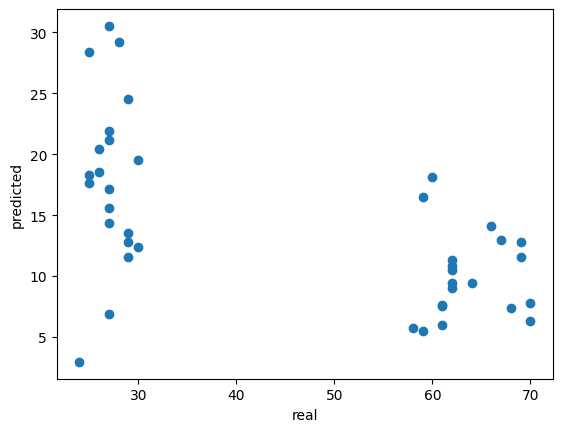

In [ ]:
plt.scatter(real_age["Donor Age"].astype(np.float64), predicted_age.astype(np.float64))
plt.xlabel('real')
plt.ylabel('predicted')

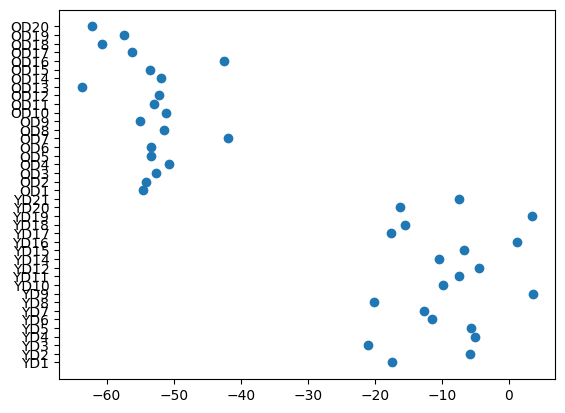

In [ ]:
plt.scatter(predicted_age.astype(np.float64) - real_age["Donor Age"].astype(np.float64), real_age["Donor ID"])